# 多头注意力
:label:`sec_multihead-attention`

在实践中，当给定相同的查询、键和值的集合时，
我们希望模型可以基于相同的注意力机制学习到不同的行为，
然后将不同的行为作为知识组合起来，
捕获序列内各种范围的依赖关系
（例如，短距离依赖和长距离依赖关系）。
因此，允许注意力机制组合使用查询、键和值的不同
*子空间表示*（representation subspaces）可能是有益的。

为此，与其只使用单独一个注意力汇聚，
我们可以用独立学习得到的$h$组不同的
*线性投影*（linear projections）来变换查询、键和值。
然后，这$h$组变换后的查询、键和值将并行地送到注意力汇聚中。
最后，将这$h$个注意力汇聚的输出拼接在一起，
并且通过另一个可以学习的线性投影进行变换，
以产生最终输出。
这种设计被称为*多头注意力*（multihead attention）
 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。
对于$h$个注意力汇聚输出，每一个注意力汇聚都被称作一个*头*（head）。
 :numref:`fig_multi-head-attention`
展示了使用全连接层来实现可学习的线性变换的多头注意力。

![多头注意力：多个头连结然后线性变换](../img/multi-head-attention.svg)
:label:`fig_multi-head-attention`

## 模型

在实现多头注意力之前，让我们用数学语言将这个模型形式化地描述出来。
给定查询$\mathbf{q} \in \mathbb{R}^{d_q}$、
键$\mathbf{k} \in \mathbb{R}^{d_k}$和
值$\mathbf{v} \in \mathbb{R}^{d_v}$，
每个注意力头$\mathbf{h}_i$（$i = 1, \ldots, h$）的计算方法为：

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

其中，可学习的参数包括
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$、
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$和
$\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$，
以及代表注意力汇聚的函数$f$。
$f$可以是 :numref:`sec_attention-scoring-functions`中的
加性注意力和缩放点积注意力。
多头注意力的输出需要经过另一个线性转换，
它对应着$h$个头连结后的结果，因此其可学习参数是
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$：

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

基于这种设计，每个头都可能会关注输入的不同部分，
可以表示比简单加权平均值更复杂的函数。


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 实现

在实现过程中通常[**选择缩放点积注意力作为每一个注意力头**]。
为了避免计算代价和参数代价的大幅增长，
我们设定$p_q = p_k = p_v = p_o / h$。
值得注意的是，如果将查询、键和值的线性变换的输出数量设置为
$p_q h = p_k h = p_v h = p_o$，
则可以并行计算$h$个头。
在下面的实现中，$p_o$是通过参数`num_hiddens`指定的。


In [2]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够[**使多个头并行计算**]，
上面的`MultiHeadAttention`类将使用下面定义的两个转置函数。
具体来说，`transpose_output`函数反转了`transpose_qkv`函数的操作。


In [3]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

下面使用键和值相同的小例子来[**测试**]我们编写的`MultiHeadAttention`类。
多头注意力输出的形状是（`batch_size`，`num_queries`，`num_hiddens`）。


In [4]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [11]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## 小结

* 多头注意力融合了来自于多个注意力汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的子空间表示。
* 基于适当的张量操作，可以实现多头注意力的并行计算。



## 练习

1. 分别可视化这个实验中的多个头的注意力权重。
1. 假设有一个完成训练的基于多头注意力的模型，现在希望修剪最不重要的注意力头以提高预测速度。如何设计实验来衡量注意力头的重要性呢？


## 练习解答
#### 1. 分别可视化这个实验中的多个头的注意力权重。

查看多头注意力权重的维度

In [25]:
attention.attention.attention_weights.shape

torch.Size([10, 4, 6])

In [29]:
attention_weights = attention.attention.attention_weights.reshape(
    batch_size, num_heads, num_queries, num_kvpairs)
# attention_weights = attention.attention.attention_weights.reshape(
#     batch_size, num_heads, num_queries, num_kvpairs)[0].unsqueeze(0)

In [30]:
attention_weights.shape

torch.Size([2, 5, 4, 6])

注意力权重可视化，上下分别为两个batch的权重

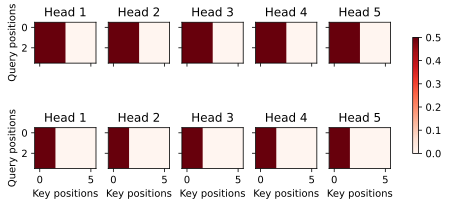

In [32]:
d2l.show_heatmaps(
    attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, attention_weights.shape[1] + 1)],
    figsize=(8, 3.5))

#### 2. 假设有一个完成训练的基于多头注意力的模型，现在希望修剪最不重要的注意力头以提高预测速度。如何设计实验来衡量注意力头的重要性呢？
为了衡量多头注意力模型中各个注意力头的重要性，并决定哪些头可以被修剪以提高预测速度，可以设计以下实验：
实验设计步骤：
1. 基线性能评估：
   - 在开始之前，记录下当前模型在验证集或测试集上的性能指标作为基线。
2. 单头修剪实验：
   - 随机选择一个注意力头进行修剪，即暂时移除该头的贡献。
   - 评估修剪后的模型性能，记录下每个被修剪头的性能变化。
3. 逐步修剪实验：
   - 从上一步中找到对性能影响最小的头开始，逐步修剪更多的头。
   - 每次修剪后都重新评估模型性能，直到达到预定的性能下降阈值或预测速度提升目标。
4. 交叉验证：
   - 使用交叉验证来确保结果的稳健性，避免因数据划分不同而导致的偶然性。
5. 统计分析：
   - 对每次修剪后的性能变化进行统计分析，确定哪些头的修剪对性能影响最小。
6. 可视化注意力权重：
   - 可视化每个注意力头的权重分布，以直观了解它们在模型中的作用。
7. 综合评估：
   - 结合性能变化和注意力权重可视化结果，综合评估每个注意力头的重要性。
实验注意事项：
- 过拟合风险：在修剪过程中要注意监控过拟合的风险，确保模型的泛化能力不受影响。
- 并行计算优势：多头注意力的一个优势是能够并行处理，因此在修剪时要考虑是否会影响这一优势。
- 维度变化：修剪注意力头可能会影响模型内部的维度变化，需要确保修剪后的模型结构仍然合理。


[Discussions](https://discuss.d2l.ai/t/5758)
